In [1]:
import math
import numpy as np
import tensorflow as tf
import cv2

slim = tf.contrib.slim
from tensorflow.contrib.slim.python.slim import queues

In [2]:
import sys
sys.path.append('../')

In [3]:
from datasets import dataset_factory
from nets import nets_factory
from preprocessing import preprocessing_factory

In [4]:
isess = tf.InteractiveSession()

## Drawing routines

In [5]:
def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """Draw a collection of lines on an image.
    """
    for line in lines:
        for x1, y1, x2, y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def draw_rectangle(img, p1, p2, color=[255, 0, 0], thickness=2):
    cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
    
    
def draw_bbox(img, bbox, shape, label, color=[255, 0, 0], thickness=2):
    p1 = (int(bbox[0] * shape[0]), int(bbox[1] * shape[1]))
    p2 = (int(bbox[2] * shape[0]), int(bbox[3] * shape[1]))
    cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
    p1 = (p1[0]+15, p1[1])
    cv2.putText(img, str(label), p1[::-1], cv2.FONT_HERSHEY_DUPLEX, 0.5, color, 1)
    

## Pascal VOC dataset

Check the data pipeline and TFRecords files.

In [6]:
from datasets import pascalvoc_2007
from datasets import pascalvoc_2012

DATASET_DIR = '/media/paul/DataExt4/PascalVOC/dataset/'
SPLIT_NAME = 'train'
BATCH_SIZE = 16

# Dataset provider loading data from the dataset.
dataset = pascalvoc_2007.get_split(SPLIT_NAME, DATASET_DIR)
provider = slim.dataset_data_provider.DatasetDataProvider(dataset, shuffle=False,
                                                          common_queue_capacity=2 * BATCH_SIZE,
                                                          common_queue_min=BATCH_SIZE)
[image, shape, bbox, label] = provider.get(['image', 'shape', 'object/bbox', 'object/label'])
print('Dataset:', dataset.data_sources)

Dataset: /media/paul/DataExt4/PascalVOC/dataset/voc_2007_train.tfrecord


In [7]:
# Problem: image shape is not fully defined => random crop with deterministic size.
xy = tf.random_uniform((2, ), minval=0, maxval=shape[0] // 3, dtype=tf.int64)
image_crop = tf.slice(image, [0, 0, 0], [250, 250, 3])
image_bboxes = tf.squeeze(tf.image.draw_bounding_boxes(tf.expand_dims(tf.to_float(image)/255., 0), tf.expand_dims(bbox, 0)))

print(image.get_shape())
print(image_crop.get_shape())
print(bbox.get_shape())
print(label.get_shape())

(?, ?, 3)
(250, 250, 3)
(?, 4)
(?,)


In [8]:
#     with queues.QueueRunners(sess):
# Start populating the filename queue.
coord = tf.train.Coordinator()
threads = tf.train.start_queue_runners(coord=coord)

In [9]:
result = isess.run([image_bboxes, shape, bbox, label])


(375, 500, 3)
[375 500   3]
[[ 0.56266665  0.52600002  0.90399998  0.648     ]
 [ 0.704       0.33000001  0.99199998  0.50599998]
 [ 0.65066665  0.01        0.99733335  0.134     ]
 [ 0.51733333  0.48199999  0.79733336  0.58999997]
 [ 0.49599999  0.55400002  0.58666664  0.62400001]]
[16 16 16 16 16]


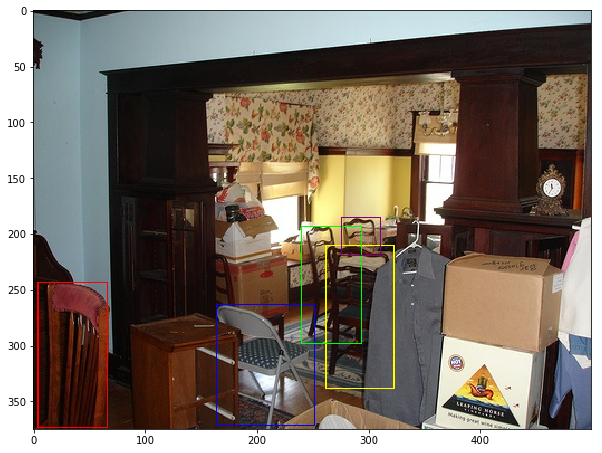

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = result[0]
img_shape = result[1]
bboxes = result[2]
# for i in range(bboxes.shape[0]):
#     draw_bbox(img, bboxes[i], img_shape, result[3][i], color=[255, 0, 0])

print(img.shape)
print(img_shape)
print(bboxes)
print(result[3])

fig = plt.figure(figsize = (10,10))
plt.imshow(img)

In [11]:
# images = tf.train.batch(
#                 [image_crop],
#                 batch_size=BATCH_SIZE,
#                 num_threads=1,
#                 capacity=5 * BATCH_SIZE)

In [12]:
# images.eval()

## Test original SSD-300 model

Restore model and test it on some random images.

In [13]:
_R_MEAN = 123.68
_G_MEAN = 116.78
_B_MEAN = 103.94

def _mean_image_subtraction(image, means):
    if image.get_shape().ndims != 3:
        raise ValueError('Input must be of size [height, width, C>0]')
    num_channels = image.get_shape().as_list()[-1]
    if len(means) != num_channels:
        raise ValueError('len(means) must match the number of channels')

    channels = tf.split(2, num_channels, image)
    for i in range(num_channels):
        channels[i] -= means[i]
    return tf.concat(2, channels)


def preprocess_for_eval(image, net_size=(300, 300), expand_size=(500, 500)):
    # Center channels.
    image = tf.to_float(image)
    image = _mean_image_subtraction(image, [_R_MEAN, _G_MEAN, _B_MEAN])
    # Crop or pad to bigger size.
#     image = tf.slice(image, [0, 0, 0], [300, 300, 3])
    image = tf.image.resize_image_with_crop_or_pad(image, expand_size[0], expand_size[1])
    image = tf.expand_dims(image, 0)
    image = tf.image.resize_images(image, net_size, method=tf.image.ResizeMethod.BILINEAR, align_corners=False)
    image = tf.squeeze(image)
    return image


def unpreprocess_image(image):
    img = np.copy(image)
    img[:, :, 0] += _R_MEAN
    img[:, :, 1] += _G_MEAN
    img[:, :, 2] += _B_MEAN
    img = img.astype(np.uint8)
    return img
    

In [15]:
from nets import ssd_vgg_300

ckpt_filename = '/media/paul/DataExt4/PascalVOC/training/ckpts/SSD_300x300_ft/ssd_300_vgg.ckpt'

In [565]:
# Crop and resize image. 
expand_size = (400, 400)
net_size = (300, 300) 
image_pre = preprocess_for_eval(image, net_size, expand_size)
image_4d = tf.expand_dims(image_pre, 0)

arg_scope = ssd_vgg_300.ssd_300_vgg_arg_scope(weight_decay=0.0005)
with slim.arg_scope(arg_scope):
    predictions, localisations, logits, end_points = ssd_vgg_300.ssd_300_vgg(image_4d, num_classes=21, is_training=False)

ValueError: Variable ssd_300_vgg/conv1/conv1_1/weights already exists, disallowed. Did you mean to set reuse=True in VarScope? Originally defined at:

  File "/home/paul/anaconda3/lib/python3.5/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 208, in variable
    caching_device=caching_device)
  File "/home/paul/anaconda3/lib/python3.5/site-packages/tensorflow/contrib/framework/python/ops/arg_scope.py", line 177, in func_with_args
    return func(*args, **current_args)
  File "/home/paul/anaconda3/lib/python3.5/site-packages/tensorflow/contrib/framework/python/ops/variables.py", line 244, in model_variable
    caching_device=caching_device, device=device)


In [566]:
# Initialize variables.
init_op = tf.global_variables_initializer()
isess.run(init_op)
# Restore SSD model.
saver = tf.train.Saver()
saver.restore(isess, ckpt_filename)

In [648]:
# Load model weights.
result = isess.run([image_4d, predictions, localisations, label])
#     result = sess.run([image, predictions, localisations, end_points])

(300, 3)
Ground truth labels:  [12 12 12]


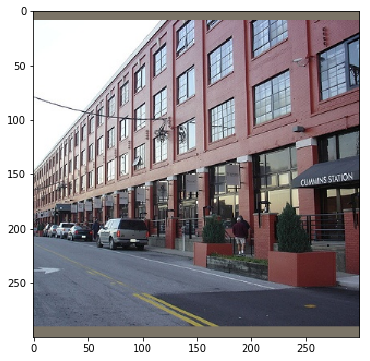

In [649]:
img = result[0][0]
img_pred = result[1]
img_loc = result[2]
img_labels = result[3]
# img_end_points = result[3]

fig = plt.figure(figsize = (6,6))
plt.imshow(unpreprocess_image(img))
print(img[:,0,:].shape)
print('Ground truth labels: ', img_labels)

In [650]:
print(image.get_shape())
print(image.dtype)

print(image_crop.get_shape())
print(image_crop.dtype)

print(image_pre.get_shape())
print(image_pre.dtype)

print(tf.shape(image)[:2])

(?, ?, 3)
<dtype: 'uint8'>
(250, 250, 3)
<dtype: 'uint8'>
(300, 300, 3)
<dtype: 'float32'>
Tensor("strided_slice_39:0", shape=(2,), dtype=int32)


In [651]:
img.ndim

3

In [652]:
def colors_subselect(colors, num_classes=21):
    dt = len(colors) // num_classes
    sub_colors = []
    for i in range(num_classes):
        color = colors[i*dt]
        if isinstance(color[0], float):
            sub_colors.append([int(c * 255) for c in color])
        else:
            sub_colors.append([c for c in color])
    return sub_colors

def bboxes_draw_on_img(img, classes, scores, bboxes, colors, thickness=2):
    shape = img.shape
    for i in range(bboxes.shape[0]):
        bbox = bboxes[i]
        color = colors[classes[i]]
        # Draw bounding box...
        p1 = (int(bbox[0] * shape[0]), int(bbox[1] * shape[1]))
        p2 = (int(bbox[2] * shape[0]), int(bbox[3] * shape[1]))
        cv2.rectangle(img, p1[::-1], p2[::-1], color, thickness)
        # Draw text...
        s = '%s/%.3f' % (classes[i], scores[i])
        p1 = (p1[0]-5, p1[1])
        cv2.putText(img, s, p1[::-1], cv2.FONT_HERSHEY_DUPLEX, 0.4, color, 1)


In [653]:
img_shape = (300, 300)
layers_shape = ssd_vgg_300.ssd_300_features_shapes
ssd_sizes = ssd_vgg_300.ssd_reference_sizes()
ssd_ratios = ssd_vgg_300.ssd_300_ratios
# Compute anchors bboxes.
layers_anchors = ssd_anchors_from_layers(img_shape, layers_shape, 
                                         ssd_sizes, ssd_ratios, offset=0.7, dtype=np.float32)


In [654]:
classes, scores, bboxes = ssd_boxes_from_layers(img_pred, img_loc, layers_anchors,
                                                threshold=0.5, img_shape=img_shape, num_classes=21)

classes, scores, bboxes = bboxes_sort(classes, scores, bboxes, top_k=400)
classes, scores, bboxes = bboxes_nms(classes, scores, bboxes, threshold=0.4)


In [655]:
r=bboxes_jaccard(bboxes, bboxes[0])
r

array([ 1.        ,  0.06861271, -0.04135131, -0.38015535], dtype=float32)

In [656]:
import matplotlib
# import matplotlib.colors.cmaps
# from colormaps import cmaps

from matplotlib import cm
cm.inferno.colors
cm.viridis.colors
cmap = cm.plasma.colors

colors = colors_subselect(cm.plasma.colors, num_classes=21)

tableau20 = [(255, 255, 255), (31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),    
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),    
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),    
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]  
len(tableau20)

21

[(7, 0.97489715), (7, 0.90814626), (7, 0.76333767), (15, 0.55112368)]


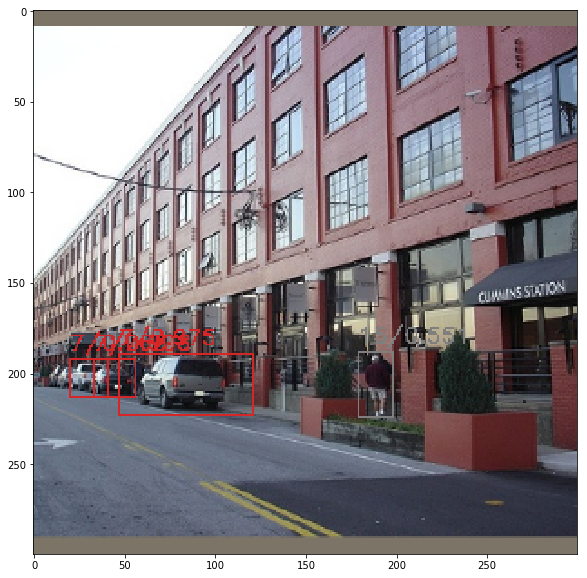

In [657]:
# Draw bboxes
img_bboxes = np.copy(unpreprocess_image(img))
bboxes_draw_on_img(img_bboxes, classes, scores, bboxes, tableau20, thickness=1)

print(list(zip(classes, scores)))
fig = plt.figure(figsize = (10,10))
plt.imshow(img_bboxes)

In [ ]:
# Request threads to stop. Just to avoid error messages
coord.request_stop()
coord.join(threads)

## Some TensorFlow tests...

In [ ]:
a = tf.constant([[5.0, 2], [5.0, 2]])
b = tf.constant([5.0, 2])
c = a * b
d = tf.nn.l2_normalize(a, dim=1)
# We can just use 'c.eval()' without passing 'sess'
print(d.eval())

## A few test on Caffe model files...

In [ ]:
import caffe
import numpy as np
from caffe.proto import caffe_pb2

caffe_filename = '/media/paul/DataExt4/PascalVOC/training/ckpts/SSD_300x300_ft/ssd_300_vgg.caffemodel'
caffemodel_params = caffe_pb2.NetParameter()
caffemodel_str = open(caffe_filename, 'rb').read()
caffemodel_params.ParseFromString(caffemodel_str)


In [ ]:
layers = caffemodel_params.layer
names = [(i, l.name) for i, l in enumerate(layers)]
types = set([l.type for i, l in enumerate(layers)])
print(types)
names

In [ ]:
layer = layers[59]
layer = layers[1]
print(layer.type)
a = np.array(layer.blobs[0].data)
s = layer.blobs[0].shape
print(s, 38*38)
# print(a)

In [ ]:
from nets import caffe_scope

In [ ]:
csc = caffe_scope.CaffeScope()


In [ ]:
d = {}
d[csc.conv_biases_init] = 0
d[csc.conv_biases_init] += 1

In [ ]:
d

In [ ]:
min_dim = 300
mbox_source_layers = ['conv4_3', 'fc7', 'conv6_2', 'conv7_2', 'conv8_2', 'conv9_2']
min_ratio = 15
max_ratio = 90
step = int(math.floor((max_ratio - min_ratio) / (len(mbox_source_layers) - 2)))
min_sizes = []
max_sizes = []
for ratio in range(min_ratio, max_ratio + 1, step):
    min_sizes.append(min_dim * ratio / 100.)
    max_sizes.append(min_dim * (ratio + step) / 100.)
min_sizes = [min_dim * 7 / 100.] + min_sizes
max_sizes = [min_dim * 15 / 100.] + max_sizes

In [ ]:
print(min_sizes)
print(max_sizes)


In [ ]:
315 / 300.

In [ ]:
np.arange(0.1, 1.0, 0.1)

In [ ]:
y, x = np.mgrid[0:4, 0:4]

In [ ]:
y

In [ ]:
y.astype()